# **Paso 1: Evaluación del modelo binario**

Found 1732 images belonging to 2 classes.
Total de imágenes en el conjunto de prueba: 1732
55/55 [==============================] - 3s 36ms/step - loss: 0.3429 - accuracy: 0.8695 - precision_10: 0.8336 - recall_10: 0.8545 - auc_10: 0.9422

Resultados de evaluación en el conjunto de prueba:
Precisión (Accuracy): 0.8695
Recall: 0.8545
Precision: 0.8336
AUC: 0.9422
55/55 [==============================] - 3s 39ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

   No Lesion       0.90      0.88      0.89      1017
      Lesion       0.83      0.85      0.84       715

    accuracy                           0.87      1732
   macro avg       0.86      0.87      0.87      1732
weighted avg       0.87      0.87      0.87      1732



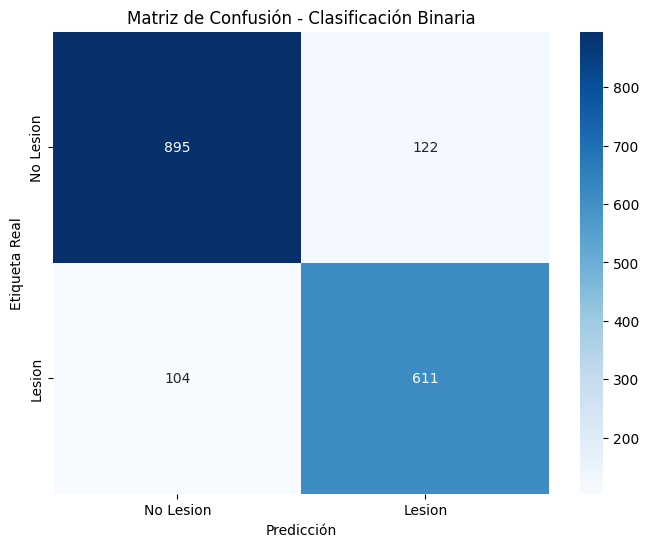

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo binario
binary_model = tf.keras.models.load_model('modelosFinales/movileNet_clasificacionBinaria_augmented.keras', compile=False)
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Directorio de prueba
test_dir = 'crops/test'

# Configuración del generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']  # Usar las clases correspondientes
)

# Verificar cantidad de imágenes en el conjunto de prueba
print(f"Total de imágenes en el conjunto de prueba: {test_generator.samples}")

# Evaluar el modelo binario en el conjunto de prueba
evaluation_metrics = binary_model.evaluate(test_generator)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics

print("\nResultados de evaluación en el conjunto de prueba:")
print(f"Precisión (Accuracy): {test_acc:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"AUC: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = binary_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes  # Etiquetas reales del generador

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=['No Lesion', 'Lesion']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# **Paso 2: Evaluación del modelo de clasificación multicategoría**

Found 715 images belonging to 5 classes.
23/23 [==============================] - 4s 177ms/step


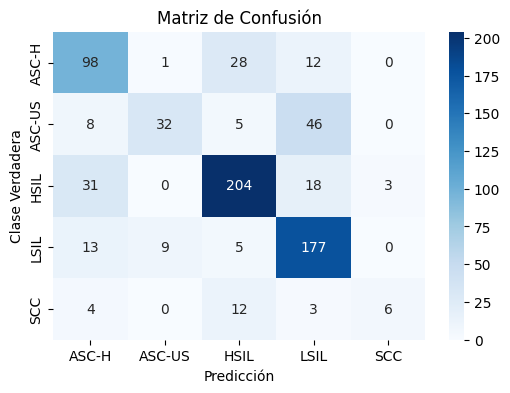

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo binario
five_classes_model = tf.keras.models.load_model('modelosFinales/xception_clasificacion5clases_augmented.keras', custom_objects={'Functional': tf.keras.models.Model}, compile=False)
five_classes_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Directorio de prueba
test_dir = 'crops/test/1_lesion'

# Configuración del generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Solo subcarpeta de lesiones
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy, test_precision, test_recall, test_auc = five_classes_model.evaluate(test_generator)

# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = five_classes_model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

23/23 [==============================] - 5s 195ms/step


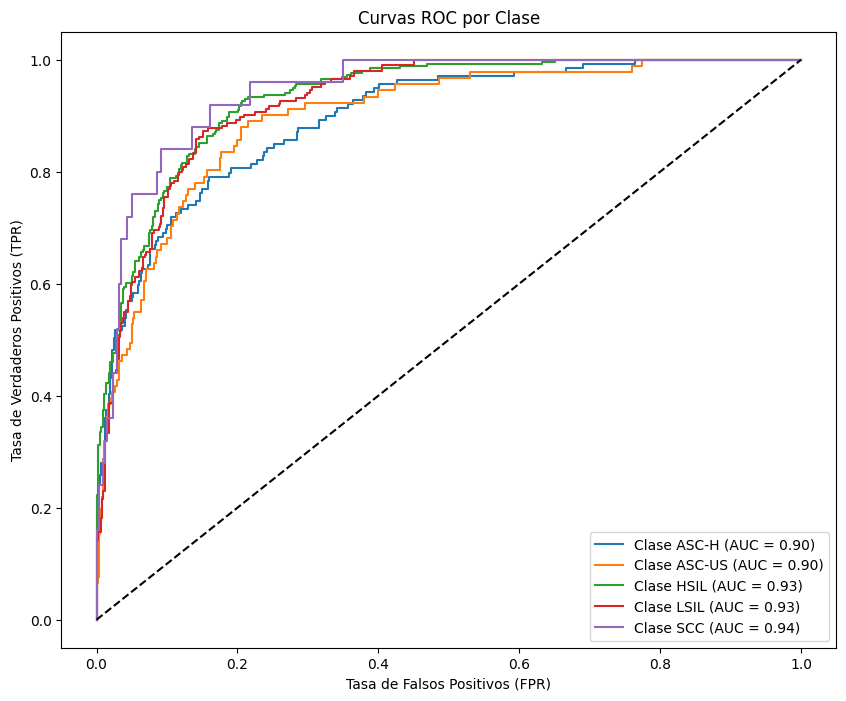

AUC Promedio: 0.92
AUC Promedio Ponderado: 0.92


In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = five_classes_model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

#  **Paso 3: Pipeline**

Found 1732 images belonging to 2 classes.
55/55 [==============================] - 2s 35ms/step


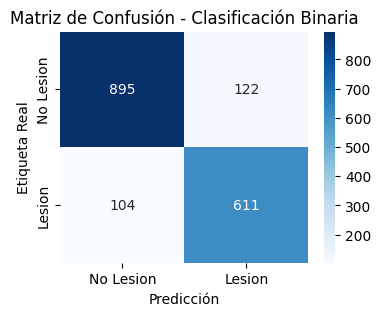

1/1 [==============================] - 0s 33ms/step


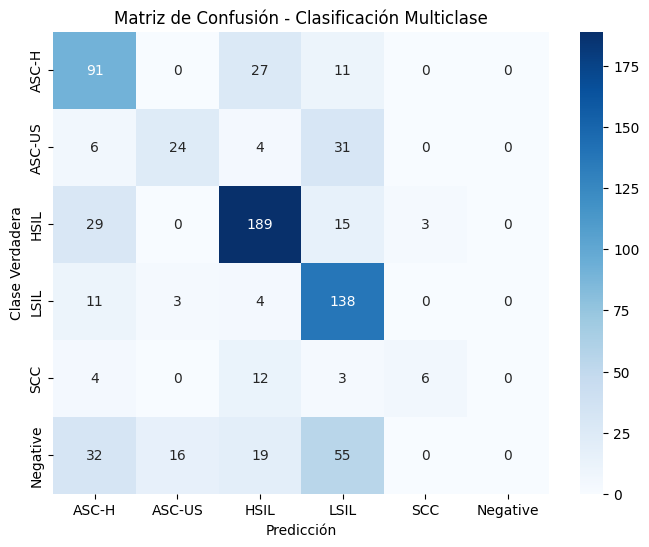

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar modelos
binary_model = tf.keras.models.load_model('modelosFinales/movileNet_clasificacionBinaria_augmented.keras', compile=False)
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


five_classes_model = tf.keras.models.load_model('modelosFinales/xception_clasificacion5clases_augmented.keras', custom_objects={'Functional': tf.keras.models.Model}, compile=False)
five_classes_model.compile(optimizer=Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',  # Pérdida para multiclase
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Directorio de prueba
test_dir = 'crops/test'

# Configuración del generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']
)

# Paso 1: Evaluar y clasificar usando el modelo binario
binary_predictions = (binary_model.predict(test_generator) > 0.5).astype(int).flatten()
y_true_binary = test_generator.classes


# Matriz de confusión
cm = confusion_matrix(y_true_binary, binary_predictions)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Crear un DataFrame para almacenar las predicciones y las rutas de archivos
binary_results_df = pd.DataFrame({
    'filepath': test_generator.filepaths,
    'true_label': y_true_binary,
    'predicted_label': binary_predictions
})

# Filtrar imágenes clasificadas como "Lesión" por el modelo binario para pasar al modelo multiclase
lesion_image_paths = binary_results_df[binary_results_df['predicted_label'] == 1]['filepath'].values

# Paso 2: Clasificar imágenes de "lesión" con el modelo de 5 clases

# Preparación para evaluación multiclase
y_true_multi = []
y_pred_multi = []

# Configurar la dimensión esperada del modelo multiclase
IMG_HEIGHT_MULTI, IMG_WIDTH_MULTI = 90, 90  # Asegurarse de que coincida con la configuración del modelo
lesion_classes = class_labels + ['Negative'] # Ajusta estas clases según tu modelo

# Paso 2: Evaluación multiclase con las imágenes clasificadas como "lesión"
for img_path in lesion_image_paths:
    # Obtener la clase verdadera desde el path de la imagen
    true_class_name = os.path.basename(os.path.dirname(img_path))

    # Procesar la imagen para el modelo de 5 clases
    img_multi = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT_MULTI, IMG_WIDTH_MULTI))
    img_array_multi = tf.keras.preprocessing.image.img_to_array(img_multi)
    img_array_multi = np.expand_dims(img_array_multi, axis=0) / 255.0

    # Realizar la predicción y almacenar los resultados
    multi_class_pred = five_classes_model.predict(img_array_multi)
    predicted_class = np.argmax(multi_class_pred, axis=1)[0]

    # Obtener el índice de la clase verdadera en `lesion_classes`
    true_class_index = lesion_classes.index(true_class_name)  # Busca el índice en la lista `lesion_classes`
    y_true_multi.append(true_class_index)
    y_pred_multi.append(predicted_class)

# Crear la matriz de confusión segundo paso
cm = confusion_matrix(y_true_multi, y_pred_multi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_classes, yticklabels=lesion_classes)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Clasificación Multiclase')
plt.show()



**Matriz de confusión final con escala original**

1/1 [==============================] - 0s 31ms/step


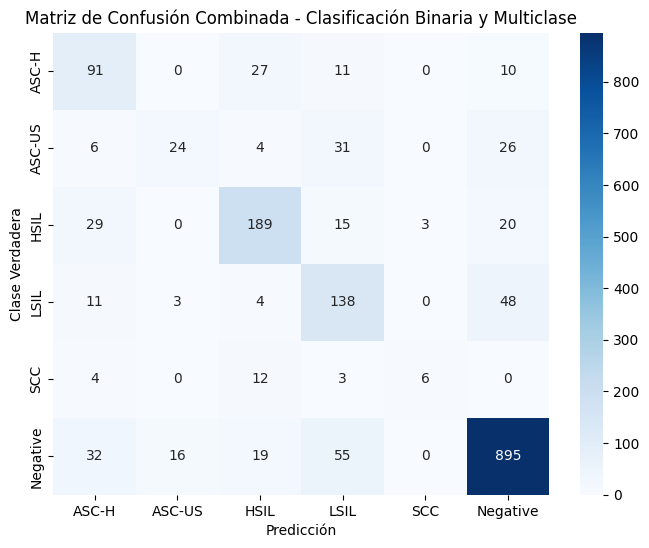

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lesion_classes = class_labels + ['Negative']

# Dividir en dos grupos: imágenes clasificadas como "Lesión" (1) y "No Lesión" (0)
lesion_indices = np.where(binary_predictions == 1)[0]
no_lesion_indices = np.where(binary_predictions == 0)[0]

# Preparar listas para las etiquetas verdaderas y predichas en la matriz de confusión combinada
y_true_combined = []
y_pred_combined = []

# Paso 1: Clasificar imágenes de "Lesión" con el modelo de 5 clases
for i in lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))  # Obtener clase verdadera desde el path
    true_class_index = lesion_classes.index(true_class_name)  # Índice de la clase verdadera

    # Procesar la imagen para el modelo multiclase
    img_multi = tf.keras.preprocessing.image.load_img(img_path, target_size=(90, 90))
    img_array_multi = tf.keras.preprocessing.image.img_to_array(img_multi)
    img_array_multi = np.expand_dims(img_array_multi, axis=0) / 255.0

    # Realizar la predicción con el modelo de 5 clases
    multi_class_pred = five_classes_model.predict(img_array_multi)
    predicted_class = np.argmax(multi_class_pred, axis=1)[0]

    # Agregar a la lista de etiquetas combinadas
    y_true_combined.append(true_class_index)
    y_pred_combined.append(predicted_class)

# Paso 2: Asignar los verdaderos negativos y falsos negativos
for i in no_lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))
    if true_class_name == "Negative":
        # Verdadero negativo: era "Negative" y el modelo lo clasificó como "Negative"
        y_true_combined.append(lesion_classes.index("Negative"))
        y_pred_combined.append(lesion_classes.index("Negative"))
    else:
        # Falso negativo: era una lesión, pero se clasificó como "Negative" en la primera etapa
        true_class_index = lesion_classes.index(true_class_name)
        y_true_combined.append(true_class_index)
        y_pred_combined.append(lesion_classes.index("Negative"))

# Crear y visualizar la matriz de confusión combinada
cm_combined = confusion_matrix(y_true_combined, y_pred_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_classes, yticklabels=lesion_classes) 
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión Combinada - Clasificación Binaria y Multiclase')
plt.show()

**Matriz de confusión final con escala ajustada**

Limitamos el valor máximo de la escala a un cuarto del valor más alto en la matriz para equilibrar el color y hacer que los errores y aciertos de las clases de lesiones sean más visibles frente al alto número de verdaderos negativos.

1/1 [==============================] - 0s 29ms/step


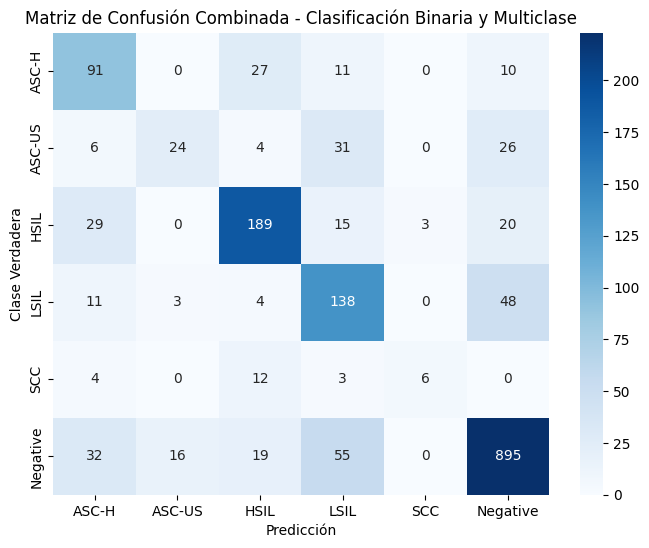

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lesion_classes = class_labels + ['Negative']

# Dividir en dos grupos: imágenes clasificadas como "Lesión" (1) y "No Lesión" (0)
lesion_indices = np.where(binary_predictions == 1)[0]
no_lesion_indices = np.where(binary_predictions == 0)[0]

# Preparar listas para las etiquetas verdaderas y predichas en la matriz de confusión combinada
y_true_combined = []
y_pred_combined = []

# Paso 1: Clasificar imágenes de "Lesión" con el modelo de 5 clases
for i in lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))  # Obtener clase verdadera desde el path
    true_class_index = lesion_classes.index(true_class_name)  # Índice de la clase verdadera

    # Procesar la imagen para el modelo multiclase
    img_multi = tf.keras.preprocessing.image.load_img(img_path, target_size=(90, 90))
    img_array_multi = tf.keras.preprocessing.image.img_to_array(img_multi)
    img_array_multi = np.expand_dims(img_array_multi, axis=0) / 255.0

    # Realizar la predicción con el modelo de 5 clases
    multi_class_pred = five_classes_model.predict(img_array_multi)
    predicted_class = np.argmax(multi_class_pred, axis=1)[0]

    # Agregar a la lista de etiquetas combinadas
    y_true_combined.append(true_class_index)
    y_pred_combined.append(predicted_class)

# Paso 2: Asignar los verdaderos negativos y falsos negativos
for i in no_lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))
    if true_class_name == "Negative":
        # Verdadero negativo: era "Negative" y el modelo lo clasificó como "Negative"
        y_true_combined.append(lesion_classes.index("Negative"))
        y_pred_combined.append(lesion_classes.index("Negative"))
    else:
        # Falso negativo: era una lesión, pero se clasificó como "Negative" en la primera etapa
        true_class_index = lesion_classes.index(true_class_name)
        y_true_combined.append(true_class_index)
        y_pred_combined.append(lesion_classes.index("Negative"))

# Crear y visualizar la matriz de confusión combinada
cm_combined = confusion_matrix(y_true_combined, y_pred_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_classes, yticklabels=lesion_classes, 
            vmax=np.max(cm_combined) // 4) 
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión Combinada - Clasificación Binaria y Multiclase')
plt.show()
